### Simple baseline

In this baseline we take data from the primary source, aggregate it by squares and compute some basic features from those squares.

We then fit a gradient boosting ensemble to predict whether it was raining in this particular square & hour.

For starters, let's take a look at our data.

In [20]:
TRAIN_PATH = "./data/train_spb.tsv"
NETATMO_PATH = "./data/train_spb_netatmo.tsv"
TEST_PATH = "./data/test_spb_features.tsv"
TEST_NETATMO_PATH = "./data/test_spb_netatmo.tsv"

CITY_PREDICTIONS_PATH = "./intermediate_data/prediction_spb.csv"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [3]:
train = pd.read_csv(TRAIN_PATH, sep='\t',dtype=json.load(open("./data/train_col_dtypes.json")))

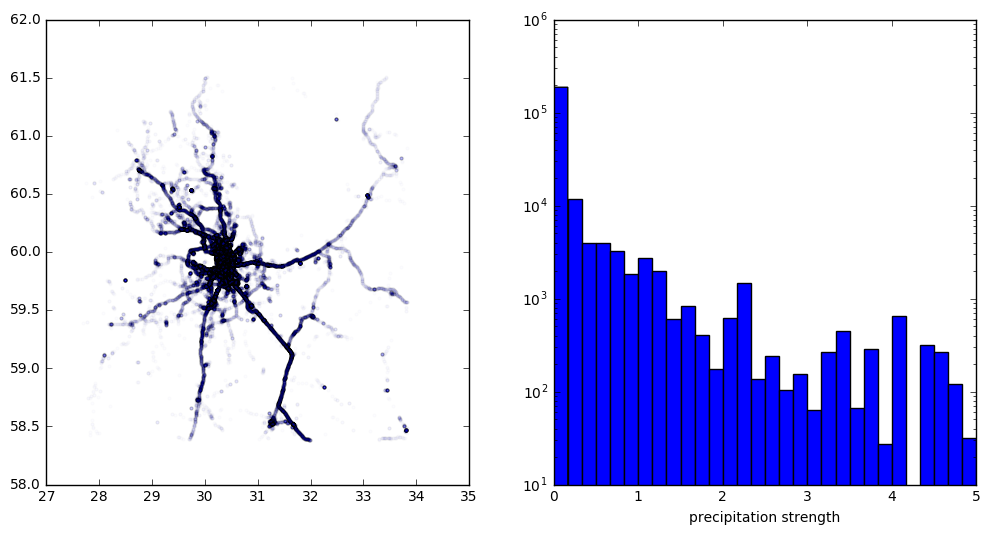

,hour_hash,sq_x,sq_y,EventTimestampDelta,day_hour,cell_hash,sq_time,radio,LocationSpeed,LAC,...,day,ver_hash,SignalStrength,rain,u_hashed,city_code,cell_lat,OperatorID,LocationTimestampDelta,device_model_hash
0,15594925468529168,-25,10,-2633,19,14651974101723141779,1499367600,-999,-999,0,...,5,10377131132567209046,-51,False,12206894233697114112,78,-999.0,2,-2604,2759912338172476928
1,15594925468529168,-25,10,-2633,19,8307254969032291552,1499367600,-999,-999,4736,...,5,10377131132567209046,-51,False,12206894233697114112,78,-999.0,2,-2604,2759912338172476928
2,15594925468529168,-25,10,-2633,19,9484285705711737699,1499367600,-999,-999,0,...,5,10377131132567209046,-51,False,12206894233697114112,78,-999.0,2,-2604,2759912338172476928
3,15594925468529168,-25,10,-2633,19,13360388985131671404,1499367600,-999,-999,0,...,5,10377131132567209046,-51,False,12206894233697114112,78,-999.0,2,-2604,2759912338172476928
4,15594925468529168,-25,10,-2633,19,7727486797820338731,1499367600,-999,-999,0,...,5,10377131132567209046,-51,False,12206894233697114112,78,-999.0,2,-2604,2759912338172476928


In [4]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.scatter(train['ulon'][::100],train['ulat'][::100],alpha=0.01,marker='.')
plt.subplot(1,2,2)
plt.hist(train['precipitation'][::100],range=[0,5],bins=30)
plt.yscale('log')
plt.xlabel("precipitation strength")
plt.show()

train.head()

__Note:__ if you're low on memory, try this:
* Most obviously, downsample data
* Read one square at a time: read it, compute features, and only then read next square
* Entries for each cell appear as subsequent rows in the dataset, so you can just read, say, 25% of the data and process it, then go for next 25%, etc.
* Delete training data and intermediate aggregations liky `groupby` after you've done with feature engineering.

#### Working with netatmo

Customer grade meteostations are excellent sources of data on rain. Alas, they're rather scarce and we're unlikely to find stations in every square/time block. Therefore we're gonna need to quickly find ones from neighboring blocks.

For performance reasons, we'll use fast nearest neighbor lookup methods from sklearn.
Note that those are not the fastest neighbor lookup methods available, but they should be enough for the baseline.

We'll query the users that have neighboring longitude/lattitude within this hour. In this baseline we implicitly compute euclidian distance over latitude/longitude axes which has a number of problems: the distance gets larger as you move from equator to the poles. More importantly, this method does not take adjacent hours into consideration.
You are invited to improve on those points in your solution :)


In [5]:
from sklearn.neighbors import KDTree
def preprocess_netatmo(df):
    """organizes netatmo stations into KDTrees for each distinct time frame"""
    
    df_by_hour = df.groupby('hour_hash')
    anns = {}
    for hour,stations_group in df_by_hour:
        anns[hour] = KDTree(stations_group[["netatmo_latitude","netatmo_longitude"]].values,metric='minkowski',p=2)
    
    #convert groupby to dict to get faster queries
    df_by_hour = {group:stations_group for group,stations_group in df_by_hour}
    
    return df_by_hour,anns
        

In [6]:
netatmo_groups,netatmo_anns = preprocess_netatmo(pd.read_csv(NETATMO_PATH,na_values="None",sep='\t',dtype={'hour_hash':"uint64"}))

## Feature engineering

In this baseline, we're going to aggregate all user data from a specific square and a specific hour to predict whether it's raining in this square. We'll split data into blocks by `[sq_lon,sq_lat,sq_time]` and process such blocks independently.

<img src="https://usercontent1.hubstatic.com/12943886_f520.jpg" width=240px>


The next cell defines a function that extracts features from such blocks. Feel free to add some new features here or drop those you believe to be harmful.

Also note that this isn't the only way to process such data. See the [known unknowns](#known_unknowns) section.

In [7]:

def extract_features(group,netatmo_groups,netatmo_anns):
    """
    Extracts all kinds of features from a dataframe containing users in one group
    """
    features = {}

    #square features
    square = {col: group[col].iloc[0] for col in group.columns}
    
    features['square_lat'] = square['sq_lat']
    features['square_lon'] = square['sq_lon']
    features['time_of_day'] = square['day_hour']

    #signal strength
    features['signal_mean'] = group['SignalStrength'].mean()
    features['signal_var'] = group['SignalStrength'].var()

    #features for each user
    group_by_user = group.groupby('u_hashed')
    group_by_user.apply(lambda group: group['ulat'].var()+group['ulon'].var())
    
    features['num_users'] = len(group_by_user)
    features['mean_entries_per_user'] = group_by_user.apply(len).mean()
    features['mean_user_signal_var'] = group_by_user.apply(
        lambda user_entries: user_entries['SignalStrength'].var()).mean()
    
    #netatmo features
    if square['hour_hash'] in netatmo_groups:
        local_stations,neighbors = netatmo_groups[square['hour_hash']],netatmo_anns[square['hour_hash']]
        [distances],[neighbor_ids] = neighbors.query([(square['sq_lat'],square['sq_lon'])],k=10)

        neighbor_stations = local_stations.iloc[neighbor_ids]

        features['distance_to_closest_station'] = np.min(distances)
        features['mean_distance_to_station'] = np.mean(distances)

        for colname in ['netatmo_pressure_mbar','netatmo_temperature_c','netatmo_sum_rain_24h',
                        'netatmo_humidity_percent',"netatmo_wind_speed_kmh","netatmo_wind_gust_speed_kmh"]:
            col = neighbor_stations[colname].dropna()
            if len(col)!=0:
                features[colname+"_mean"],features[colname+"_std"] = col.mean(),col.var()
            else:
                features[colname+"_mean"],features[colname+"_std"] = np.nan,np.nan

    return features
    

We now apply it to all the squares we have.

This may take time, more so if you use complex features, so you can try to speed stuff up by using [joblib.Parallel](http://pythonhosted.org/joblib/parallel.html) or similar.

In [8]:
from tqdm import tqdm

groupby = train.groupby(["city_code","sq_x","sq_y","hour_hash"])

X,y,block_ids = [],[],[]

for block_id in tqdm(groupby.groups):
    group = groupby.get_group(block_id)
    X.append(extract_features(group,netatmo_groups,netatmo_anns))
    y.append(group.iloc[0]['rain'])
    block_ids.append(block_id+(group.iloc[0]["hours_since"],))

X = pd.DataFrame(X).fillna(-999.)
y = np.array(y)
block_ids = pd.DataFrame(block_ids,columns=["city_code","sq_x","sq_y","hour_hash","hours_since"])

100%|██████████| 32803/32803 [11:34<00:00, 50.10it/s]


__Note:__ If you're low on memory, it's time to either delete train & groupby or pickle X/y/block_ids and restart.

### Classifier

Once the data is processed, it's time to train some machine learning model that would predict rain given all features we gathered.

Since our features are all of different nature and unit scale (hours,decibels,degrees,etc.), it makes sense to use decision tree-based methods to for classification.


<img src="http://zdnet2.cbsistatic.com/hub/i/2017/07/18/d3f47c3e-8529-4855-a0e1-c686ee3b4007/d1113adf74bb59c3b46419a531c39c3e/orig.png" width=320>
In particular, we apply [CatBoost](https://catboost.yandex/), Yandex' recent open source gradient boosting implementation.

To make this baseline simple, we use catboost with default settings. You can certainly find a better combination of parameters. 

Here's a [guide](https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/) on how catboost hyperparameters work.

In [9]:
in_train = block_ids['hours_since'] <= np.percentile(block_ids['hours_since'],85) #leave last 15% for validation

X_train,y_train = X[in_train],y[in_train]
X_val,y_val = X[~in_train],y[~in_train]
print("Training samples: %i; Validation samples: %i"%(len(X_train),len(X_val)))

Training samples: 28041; Validation samples: 4762


In [10]:
#if you don't have catboost installed, use !pip install catboost
from catboost import CatBoostClassifier

model = CatBoostClassifier().fit(X_train,y_train)

### Analyzing results

Here you can see importances of all individual features, ranked from worst to best.



('Train ROC AUC:', 0.87588560898983947)
('Val ROC AUC:', 0.7036089537743091)


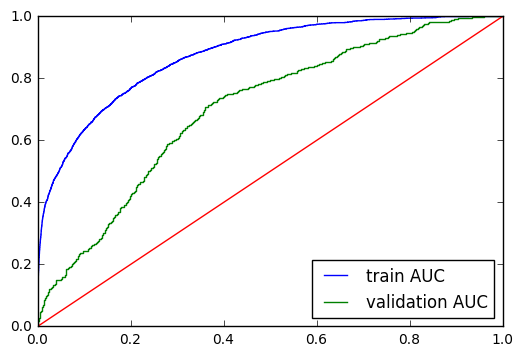

In [11]:
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

y_train_pred = model.predict_proba(X_train)[:,1]
print("Train ROC AUC:",roc_auc_score(y_train,y_train_pred))

fpr,tpr,_ = roc_curve(y_train, y_train_pred)
plt.plot(fpr,tpr,label='train AUC')

y_val_pred = model.predict_proba(X_val)[:,1]
print("Val ROC AUC:",roc_auc_score(y_val,y_val_pred))

fpr,tpr,_ = roc_curve(y_val, y_val_pred)
plt.plot(fpr,tpr,label='validation AUC')

plt.plot([0,1],[0,1])
plt.legend(loc='lower right')

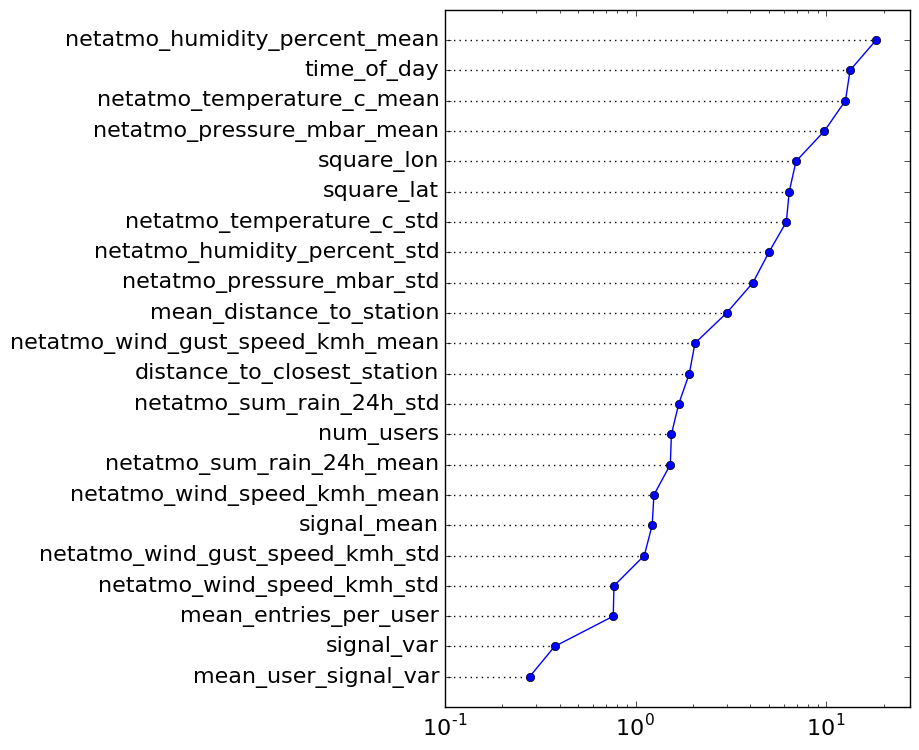

In [12]:
order = np.argsort(model._feature_importance)
plt.figure(figsize=[6,9])
plt.plot(np.array(model._feature_importance)[order],range(len(order)),marker='o')
plt.hlines(range(len(order)),np.zeros_like(order),np.array(model._feature_importance)[order],linestyles=':')
plt.yticks(range(X.shape[1]),X.columns[order]);
plt.tick_params(labelsize=16)
plt.xlim([0.1,max(model._feature_importance)*1.5])
plt.ylim(-1,len(order))
plt.xscale('log')

## Final model and uploading the results


Competition data contains three cities: Moscow, Saint-Petersburg and Kazan. To submit a prediction, you'll have to run this baseline three times separately for each city and concatenate the results. 

The code assumes that you ran this solution for each city (see comments below).

In [13]:
#Train the model on full data. Copy model definition here.

model = CatBoostClassifier().fit(X,y)

In [14]:

test = pd.read_csv(TEST_PATH, sep='\t',dtype=json.load(open("./data/test_col_dtypes.json")),)
test_groupby = test.groupby(["city_code","sq_x","sq_y","hour_hash"])
test_netatmo_groups,test_netatmo_anns = preprocess_netatmo(pd.read_csv(TEST_NETATMO_PATH,na_values="None",
                                                                       sep='\t',dtype={'hour_hash':"uint64"}))


In [15]:
X_test,test_block_ids = [],[]
for block_id in tqdm(test_groupby.groups):
    group = test_groupby.get_group(block_id)
    X_test.append(extract_features(group,test_netatmo_groups,test_netatmo_anns))
    test_block_ids.append(block_id)
    
X_test = pd.DataFrame(X_test)
test_block_ids = pd.DataFrame(test_block_ids,columns=["city_code","sq_x","sq_y","hour_hash"])

100%|██████████| 10145/10145 [03:26<00:00, 45.87it/s]


In [21]:
#This code saves the prediction for one city.
prediction_for_one_city = test_block_ids.copy()
prediction_for_one_city["prediction"] = model.predict_proba(X_test)[:,1]
prediction_for_one_city.to_csv(CITY_PREDICTIONS_PATH)

prediction_for_one_city.head()

#WARNING! you must run this notebook for all three regions before proceeding!
#We assume that you have prediction_msk.csv , prediction_spb.csv and prediction_kazan.csv files prepared.

,city_code,sq_x,sq_y,hour_hash,prediction
0,78,-21,-4,7779077882353771153,0.112725
1,78,-2,1,2590896978740453492,0.096709
2,78,-11,5,8792171690991786686,0.142509
3,78,-6,3,3088439934333900884,0.139995
4,78,-12,7,2347734849518747880,0.185624


In [51]:
data = X.copy()
data["target"] = y
data.to_csv("intermediate_data/spb.csv")
X_test.to_csv("intermediate_data/spb_test.csv")

Gather all predictions and make submission file.

In [46]:
import pandas as pd

predictions = pd.concat(
    [pd.read_csv(fname,index_col=0) for fname in ("./intermediate_data/prediction_kazan.csv",
                                                  "./intermediate_data/prediction_spb.csv",
                                                  "./intermediate_data/prediction_msk.csv")],
    ignore_index=True
)
blocks = pd.read_csv("./data/hackathon_tosubmit.tsv",sep='\t')
assert len(predictions) == len(blocks),"Predictions don't match blocks. Sumbit at your own risk."

merged = pd.merge(blocks,predictions,how='left',on=["sq_x","sq_y","hour_hash"])
assert not np.isnan(merged.prediction).any(), "some predictions are missing. Sumbit at your own risk."


In [49]:
merged[['id','prediction']].to_csv("baseline_submission.csv",sep=',',index=False,header=False)

You can now upload baseline_submission.csv to the competition interface.

In [50]:
!head baseline_submission.csv

1,0.0155932595314
2,0.0167372567601
3,0.0241957554127
4,0.0222871426346
5,0.0241935663775
6,0.0275104387343
7,0.01226118406
8,0.0864991022265
9,0.0352762465574
10,0.0245422672273


### Known unknowns <a id='known_unknowns'>

Here's a few ideas to improve your solution:
* Right now we only consider users in the same square where we're going to make prediction.
 * It may be useful to consider neighboring squares in square id and/or time
 * It may be useful to use global city-wide estimate (like "There's currently no rain in Moscow")
 * Same is true for netatmo stations
* There's a lot of underexplored features
 * Netatmo stations' features
 * User behavior on device level, e.g. "phone signal worse than usual"
 * Latitude/longitude are fed to model in 
 * Relations between several  kinds of features (e.g. signal over distance to cell)
 * Relations over location/time, e.g. "less users than usual"
* Data splits
 * Test set rains may be more/less frequent than on the training set
 * There also may be some difference in user activity
 * There's definitely a difference in distribution of users and stations in different cities
 * We only train model on one fixed region. Try using several regions at once to get more training data.



 ```
 
 ```

![img](https://images-na.ssl-images-amazon.com/images/I/31la29lBQxL.jpg)


 ```
 
 ```
